## Write You Own Frontend Parser for `utensor_cgen`

- Goal: write a parser which can parse a txt file
- the format of the txt file
```
<op_name> <value>
```
- To simplify the tutorial, we only support `Const` operator
- the `value` field is a python expression, such as `[1, 2, 3]`

In [1]:
import os

import numpy as np

from utensor_cgen.frontend import FrontendSelector, Parser
from utensor_cgen.ir import OperationInfo, TensorInfo, uTensorGraph
from utensor_cgen.ir.converter import (AttrValueConverter,
                                       GenericTensorConverterMixin)
from utensor_cgen.utils import topologic_order_graph

## The `Parser` Interface

- must overwrite `parse` method with signature `parse(model_file, output_nodes, *args, **kwargs)`
    - that is, the first argument must be model file and the second arguement must be output nodes
    - in some parser, `output_nodes` can be optional. It recommended to set it to `None`
- Register the parser with `FrontendSelector.register`
    - the first argument of `FrontendSelector.register` should be a list of file extensions, such as `['.pb', '.pbtxt']`.
    - In this tutorial, our target file is txt so the target extensions list is `['.txt']`
- If you register a parser to a file extension that has been registered with other parsers, an error will be raised. To disable this, you must explicit pass `overwrite=True` in the register decorator

In [2]:
@FrontendSelector.register(['.txt'], overwrite=True)
class TxtParser(Parser):
    def parse(self, txt_file, output_nodes=None):
        graph_name, _ = os.path.splitext(
            os.path.basename(txt_file)
        )
        if output_nodes is None:
            output_nodes = []
        add_all_nodes = not output_nodes
        ugraph = uTensorGraph(name=graph_name, output_nodes=output_nodes, lib_name='txtlib')
        with open(txt_file, 'r') as fid:
            # read lines
            for line in fid:
                try:
                    op_name, value = line.split(' ', maxsplit=1)
                except Exception:
                    raise ValueError('invalid line: {}'.format(line))
                value = np.array(eval(value))
                # construct tensors
                out_tensor = TensorInfo(
                    '{}:0'.format(op_name),
                    op_name,
                    dtype=value.dtype,
                    shape=list(value.shape),
                    ugraph=ugraph
                )
                # construct ops
                op_info = OperationInfo(
                    name=op_name,
                    lib_name='txtlib',
                    ugraph=ugraph,
                    input_tensors=[],
                    output_tensors=[out_tensor],
                    op_type='Const',
                    op_attr={
                        "value": AttrValueConverter.GenericType(
                            value_name="tensor",
                            value=GenericTensorConverterMixin.GenericType(
                                np_array=value
                            ),
                        )
                    }
                )
                if add_all_nodes:
                    ugraph.output_nodes.append(op_name)
        # topologically sort the graph
        # this will update `ugraph.topo_order`
        topologic_order_graph(ugraph)
        return ugraph

In [3]:
parser = TxtParser({})

In [4]:
ugraph = parser.parse('models/consts_model.txt')

In [5]:
ugraph

uTensorGraph(name='consts_model', output_nodes=['x', 'y'], _lib_name='txtlib', ops_info={'x': ('x', 'Const'), 'y': ('y', 'Const')}, topo_order=['x', 'y'])

In [6]:
# simple visualization
from utensor_cgen.ir.misc.graph_viz import viz_graph

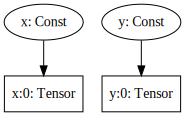

In [7]:
viz_graph(ugraph)